In [9]:
import numpy as np
from scipy.spatial import Delaunay, KDTree
import matplotlib.pyplot as plt

# Step 1: Preprocess the core data
def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    coordinates = np.array([(core['x'], core['y']) for core in cores])
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array([(x - min_x, max_y - y) for x, y in coordinates])
    return normalized_inverted_coordinates

import numpy as np
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans

# Step 1: Perform Delaunay triangulation and get all edges
def get_all_edges_from_triangulation(triangulation):
    edges = set()
    # For each triangle, add edges to the set, avoiding duplicates
    for simplex in triangulation.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            edges.add(edge)
    return np.array(list(edges))


# Step 2: Delaunay triangulation
def delaunay_triangulation(coordinates):
    """
    Perform Delaunay triangulation on the coordinates.
    :param coordinates: Array of coordinates.
    :return: Delaunay object containing the triangulation.
    """
    return Delaunay(coordinates)

# Step 2: Edge length filtering function
def filter_edges_by_length(edges, coordinates, threshold_multiplier=1):
    edge_lengths = [np.linalg.norm(coordinates[edge[0]] - coordinates[edge[1]]) for edge in edges]
    edge_lengths = np.array(edge_lengths)
    
    Q1, Q3 = np.percentile(edge_lengths, [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (threshold_multiplier * IQR)
    upper_bound = Q3 + (threshold_multiplier * IQR)

    filtered_edges = edges[(edge_lengths >= lower_bound) & (edge_lengths <= upper_bound)]
    
    return filtered_edges

# Step 3: Angle filtering function
from sklearn.cluster import KMeans

def filter_edges_by_angle(edges, coordinates, delta=0):
    # Calculate edge angles and adjust by δ
    angles = np.array([np.arctan2(coordinates[edge[1]][1] - coordinates[edge[0]][1], 
                                   coordinates[edge[1]][0] - coordinates[edge[0]][0])
                       for edge in edges])
    
    # Normalize angles to [0, 2*pi) and adjust by delta
    angles = (angles + delta) % (2 * np.pi)
    
    # Use k-means clustering to find clusters around expected angles
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(angles.reshape(-1, 1))
    
    # Determine which cluster corresponds to near-horizontal angles
    # This requires examining the cluster centers and selecting the one closest to 0 + δ or π + δ
    cluster_centers = kmeans.cluster_centers_.flatten()
    horizontal_clusters = []
    for expected_angle in [0, np.pi]:  # Horizontal angles adjusted by δ
        adjusted_angle = (expected_angle + delta) % (2 * np.pi)
        horizontal_clusters.append(np.argmin(np.abs(cluster_centers - adjusted_angle)))
    
    # Filter edges based on their cluster label being one of the horizontal clusters
    filtered_edge_indices = np.isin(kmeans.labels_.flatten(), horizontal_clusters)
    filtered_edges = np.array(edges)[filtered_edge_indices]
    
    return filtered_edges


# Step 5: The traveling algorithm (Placeholder)
def traveling_algorithm(coordinates, delta, core_to_core_distance):
    """
    Perform the traveling algorithm to visit all cores in a grid-like pattern.
    """
    num_cores = len(coordinates)
    visited = np.zeros(num_cores, dtype=bool)
    path = []

    # Start with the first core
    current = 0
    visited[current] = True
    path.append(current)
    angle_threshold = 5 + delta  # Small angle to account for grid imperfections

    while not np.all(visited):
        # Find the closest unvisited neighbor in the x-direction
        candidate_indices = np.where(~visited)[0]
        closest_neighbor = find_closest_neighbor(current, candidate_indices, coordinates, angle_threshold)
        
        if closest_neighbor is not None:
            # Move to the closest neighbor if found
            current = closest_neighbor
            visited[current] = True
            path.append(current)
        else:
            # No more neighbors, perform a circular sector search for the next core
            current = circular_sector_search(current, coordinates, visited, core_to_core_distance, delta)
            if current is None:
                break  # No next core found, we are done
            visited[current] = True
            path.append(current)

    return path

def find_closest_neighbor(current_index, candidate_indices, coordinates, angle_threshold):
    """
    Find the closest neighbor within an angular threshold.
    """
    current_coord = coordinates[current_index]
    min_distance = float('inf')
    closest_neighbor = None

    for i in candidate_indices:
        if i == current_index:
            continue
        candidate_coord = coordinates[i]
        angle = np.rad2deg(np.arctan2(candidate_coord[1] - current_coord[1], candidate_coord[0] - current_coord[0]))
        distance = np.linalg.norm(candidate_coord - current_coord)
        
        # Check if the angle is within the threshold
        if -angle_threshold <= angle <= angle_threshold and distance < min_distance:
            min_distance = distance
            closest_neighbor = i

    return closest_neighbor

def circular_sector_search(current, coordinates, visited, core_to_core_distance, delta):
    """
    Search for the next core to visit using a circular sector search.
    """
    # Search parameters
    search_angle = 5  # The angular width of the search sector, needs calibration
    search_radius = 1.5 * core_to_core_distance  # Search radius
    
    current_coord = coordinates[current]
    unvisited_indices = np.where(~visited)[0]
    candidate_coords = coordinates[unvisited_indices]
    
    # Compute the angles and distances to all unvisited cores
    angles = np.rad2deg(np.arctan2(candidate_coords[:, 1] - current_coord[1], candidate_coords[:, 0] - current_coord[0]))
    distances = np.linalg.norm(candidate_coords - current_coord, axis=1)

    # Filter candidates within the search sector
    candidate_mask = (distances <= search_radius) & (np.abs(angles) <= search_angle)
    candidates_within_sector = unvisited_indices[candidate_mask]
    distances_within_sector = distances[candidate_mask]
    
    if len(candidates_within_sector) == 0:
        return None  # No candidates found
    
    # Select the closest candidate within the sector
    next_index = candidates_within_sector[np.argmin(distances_within_sector)]
    return next_index

In [5]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def visualize_delaunay_triangulation(coordinates, triangulation):
    plt.figure(figsize=(10, 6))
    plt.triplot(coordinates[:, 0], coordinates[:, 1], triangulation.simplices, color='grey', alpha=0.5)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Initial Delaunay Triangulation')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_length_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='blue', linewidths=1)
    
    plt.figure(figsize=(10, 6))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Length Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_angle_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='red', linewidths=1)
    
    plt.figure(figsize=(10, 6))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Angle Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_traveling_algorithm(coordinates, path):
    path_coords = coordinates[path]
    
    plt.figure(figsize=(10, 6))
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'o-', color='green')
    plt.title('Traveling Algorithm Path')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Combined visualization of edges after length and angle filtering
def visualize_filtered_edges(coordinates, length_filtered_edges, angle_filtered_edges):
    # Combine the edges from both filtering steps
    remaining_edges = length_filtered_edges.intersection(angle_filtered_edges)

    # Prepare the line collection for visualization
    lines = [coordinates[list(edge)] for edge in remaining_edges]
    lc = LineCollection(lines, colors='purple', linewidths=1)
    
    plt.figure(figsize=(10, 6))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edges after Length and Angle Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    return remaining_edges  # Return the combined edges for use in the traveling algorithm


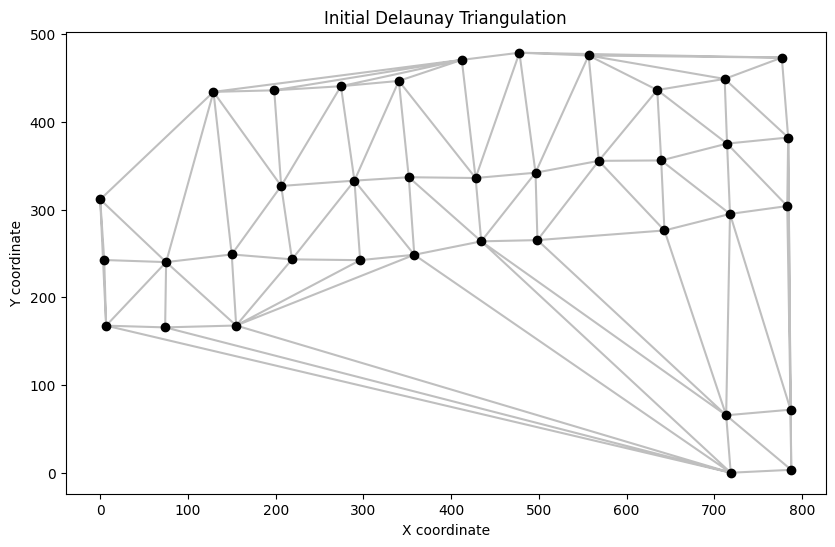

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


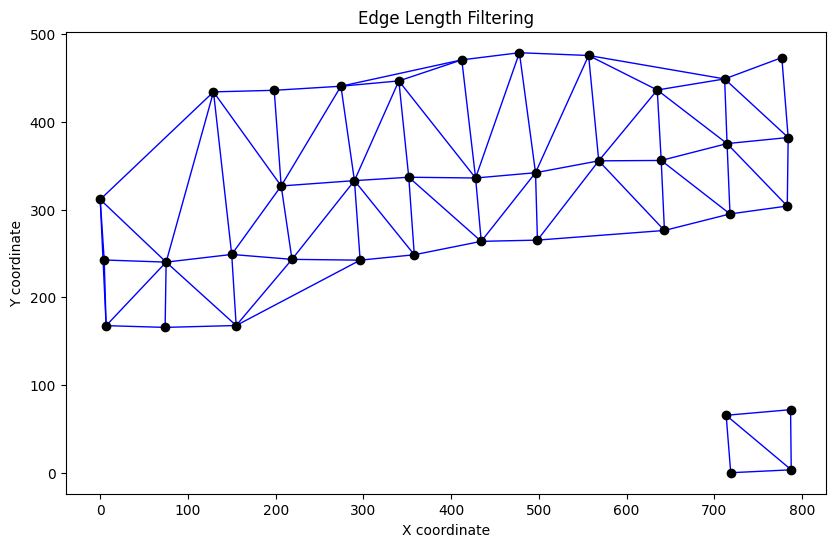

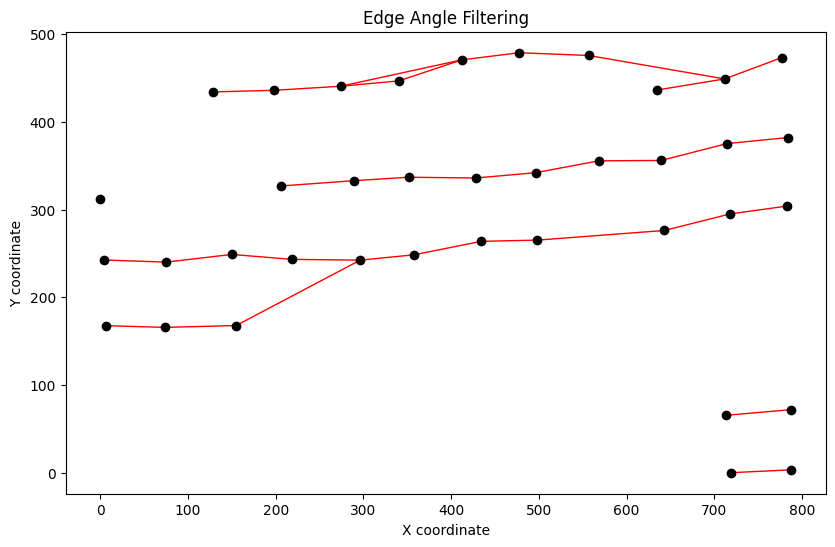

In [11]:
import pandas as pd
# Main workflow
data = pd.read_json('./TMA_WSI_Labels_updated/ABC_109_1_010_1.json')
data = data.to_dict('records')

# Convert the data to the required format if necessary
cores = data  # Assuming 'data' is already in the correct format

# Perform initial Delaunay triangulation
# Example usage in the pipeline
normalized_coordinates = preprocess_cores(data)
triangulation = Delaunay(normalized_coordinates)
visualize_delaunay_triangulation(normalized_coordinates, triangulation)


all_edges = get_all_edges_from_triangulation(triangulation)
length_filtered_edges = filter_edges_by_length(all_edges, normalized_coordinates)
angle_filtered_edges = filter_edges_by_angle(length_filtered_edges, normalized_coordinates, delta=90)



visualize_edge_length_filtering(normalized_coordinates, length_filtered_edges)

visualize_edge_angle_filtering(normalized_coordinates, angle_filtered_edges)

# visualize_traveling_algorithm(normalized_coordinates, path)

